### DefectNet: Universal defect predictor

Let's start from loading our data and preprocess it.

In [1]:
import pandas as pd
raw_data = pd.read_pickle('DefectNet_data_v0.1.pkl')

Now we encode these elements into processed `torch.Tensor` and build a dataset.

In [4]:
import re
import numpy as np
import torch
from tqdm import tqdm
import torch.nn.functional as F
from scipy.ndimage import gaussian_filter1d

# Atomic number dictionary
atomic_numbers = {
    'H': 1, 'He': 2, 'Li': 3, 'Be': 4, 'B': 5, 'C': 6, 'N': 7, 'O': 8, 'F': 9, 'Ne': 10,
    'Na': 11, 'Mg': 12, 'Al': 13, 'Si': 14, 'P': 15, 'S': 16, 'Cl': 17, 'Ar': 18,
    'K': 19, 'Ca': 20, 'Sc': 21, 'Ti': 22, 'V': 23, 'Cr': 24, 'Mn': 25, 'Fe': 26,
    'Co': 27, 'Ni': 28, 'Cu': 29, 'Zn': 30, 'Ga': 31, 'Ge': 32, 'As': 33, 'Se': 34,
    'Br': 35, 'Kr': 36, 'Rb': 37, 'Sr': 38, 'Y': 39, 'Zr': 40, 'Nb': 41, 'Mo': 42,
    'Tc': 43, 'Ru': 44, 'Rh': 45, 'Pd': 46, 'Ag': 47, 'Cd': 48, 'In': 49, 'Sn': 50,
    'Sb': 51, 'Te': 52, 'I': 53, 'Xe': 54, 'Cs': 55, 'Ba': 56
}
num_to_symbol = {v: k for k, v in atomic_numbers.items()}
num_to_symbol[0] = 'Vac'

MAX_LENGTH = 100
VECTOR_LENGTH = len(atomic_numbers) + 1  # 56+1 for vacancy
DOS_FACTOR = 28
DOPE_FACTOR = 10
Difficulty = 0.5 # higher means higher probability of adding more distractive dopants

# Function to parse formula into vector representation
def parse_formula(formula):
    element_counts = {}
    matches = re.findall(r'([A-Z][a-z]*)(\d*)', formula)
    for element, count in matches:
        count = int(count) if count else 1
        element_counts[element] = element_counts.get(element, 0) + count

    return element_counts

# Function to convert formula to vector
def formula_to_vector(formula_counts):
    vector = np.zeros(VECTOR_LENGTH, dtype=np.float64)
    total_atoms = sum(formula_counts.values())

    for element, count in formula_counts.items():
        if element in atomic_numbers:
            vector[atomic_numbers[element]] = count / total_atoms

    return vector, total_atoms

# Function to process dataset
def process_entry(row):
    # Process formula_j0
    formula_j0_counts = parse_formula(row["formula_j0"])
    formula_j0_vector, total_atoms_j0 = formula_to_vector(formula_j0_counts)

    # Process formula_j
    formula_j_counts = parse_formula(row["formula_j"])
    formula_j_vector, total_atoms_j = formula_to_vector(formula_j_counts)

    # Compute elemental difference and vacancy ratio
    diff_vector = np.zeros(VECTOR_LENGTH, dtype=np.float64)
    
    for element, count in formula_j_counts.items():
        if element in atomic_numbers and element not in formula_j0_counts:
            diff_vector[atomic_numbers[element]] = count / total_atoms_j0
    #print(diff_vector)
    
    vacancy_count = total_atoms_j0 - total_atoms_j
    diff_vector[0] = vacancy_count / total_atoms_j0
    diff_vector = diff_vector * DOPE_FACTOR

    # Process eigvals_j0 and eigvals_j
    dos_j0, _ = np.histogram(np.real(row["eigvals_j0"]), bins=100, density=True)
    # align dos_j0 with dos_j, facilitate substraction
    dos_j, _ = np.histogram(np.real(row["eigvals_j"]), bins=100, range=(np.real(row["eigvals_j0"]).min(), \
                                                                np.real(row["eigvals_j0"]).max()), density=True)
    
    # (Optional) Smooth the DOS using Gaussian filter
    # dos_j0 = gaussian_filter1d(dos_j0, sigma=1.0)
    # dos_j = gaussian_filter1d(dos_j, sigma=1.0)

    dos_j0 = torch.tensor(dos_j0, dtype=torch.float64) / DOS_FACTOR
    # dos_j = torch.tensor(dos_j, dtype=torch.float64) / DOS_FACTOR
    dos_j = torch.tensor(np.log10((dos_j / DOS_FACTOR + 1e-2) / (dos_j0 + 1e-2)), dtype=torch.float64)

    # Process dopant_options
    dopant_vector = np.zeros(VECTOR_LENGTH, dtype=np.float64)
    dopant_vector[0] = 1 # vacancy always possible
    dopants = row["dopant_options_j0"]
    for dopant in dopants:
        if dopant in atomic_numbers:
            if diff_vector[atomic_numbers[dopant]] == 0:
                if np.random.rand() < Difficulty:
                    dopant_vector[atomic_numbers[dopant]] = 1
            else:
                dopant_vector[atomic_numbers[dopant]] = 1

    return dos_j0, dos_j, torch.tensor(dopant_vector), F.pad(torch.tensor(formula_j0_vector, dtype=torch.float64),\
                                               (0, MAX_LENGTH-VECTOR_LENGTH), value=0.0), torch.tensor(diff_vector)


In [5]:
for i in process_entry(raw_data.iloc[0]):
    print(i.shape, end=',')

torch.Size([100]),torch.Size([100]),torch.Size([57]),torch.Size([100]),torch.Size([57]),

/tmp/ipykernel_11161/3427572088.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dos_j = torch.tensor(np.log10((dos_j / DOS_FACTOR + 1e-2) / (dos_j0 + 1e-2)), dtype=torch.float64)


Perfect, now let's construct dataset.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm

class MaterialsDataset(Dataset):
    def __init__(self, dataframe):
        self.data = [process_entry(row) for _, row in tqdm(dataframe.iterrows(), total=len(dataframe))]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        dos_j0, dos_j, dopant_vector, formula_j0_vector, diff_vector = self.data[idx]

        # Convert to tensors
        dos_j0 = torch.tensor(dos_j0, dtype=torch.float32)  # Original DOS
        dos_j = torch.tensor(dos_j, dtype=torch.float32)  # Modified DOS
        dopant_vector = torch.tensor(dopant_vector, dtype=torch.float32)  # Binary dopant selection
        formula_j0_vector = torch.tensor(formula_j0_vector, dtype=torch.float32)  # Extra stacked channel
        diff_vector = torch.tensor(diff_vector, dtype=torch.float32)  # Output concentration

        return dos_j0, dos_j, dopant_vector, formula_j0_vector, diff_vector

# Create dataset
dataset = MaterialsDataset(raw_data)
# torch.save(dataset, 'total_dataset.pt')

# Split dataset (80% Train, 10% Validation, 10% Test)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size  # Ensure full coverage

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


  0%|          | 0/13209 [00:00<?, ?it/s]/tmp/ipykernel_11161/3427572088.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dos_j = torch.tensor(np.log10((dos_j / DOS_FACTOR + 1e-2) / (dos_j0 + 1e-2)), dtype=torch.float64)
100%|██████████| 13209/13209 [00:09<00:00, 1446.78it/s]


DefectNet. Attention is all you need!

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DefectNet(nn.Module):
    def __init__(self, signal_length=100, num_dopants=57, embed_dim=128, num_heads=8, hidden_dim=256):
        super(DefectNet, self).__init__()

        # 1D Convolution to extract features from input curves + formula vector
        self.conv1 = nn.Conv1d(3, 32, kernel_size=5, stride=1, padding=2)  # 3 channels: dos_j0, dos_j, formula_j0
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv1d(64, embed_dim, kernel_size=5, stride=1, padding=2)

        # Embedding layer for dopant options (binary vector)
        self.dopant_embedding = nn.Linear(num_dopants, embed_dim)

        # Self-attention block
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

        # Fully connected layers for concentration prediction
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_dopants)  # Predict concentrations

    def forward(self, dos_j0, dos_j, dopant_options, formula_j0_vector):
        """
        Inputs:
        - dos_j0: (batch, signal_length) - Original DOS
        - dos_j: (batch, signal_length) - Modified DOS
        - dopant_options: (batch, num_dopants) - Binary dopant selection
        - formula_j0_vector: (batch, signal_length) - Extra input channel (zero-padded to 100)

        Returns:
        - Concentration predictions (batch, num_dopants)
        """

        # Stack the input curves together (3 channels)
        x = torch.stack([dos_j0, dos_j, formula_j0_vector], dim=1)  # Shape: (batch, 3, signal_length)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)  # Shape: (batch, embed_dim, signal_length)

        # Convert to sequence for attention (batch, length, embed_dim)
        x = x.permute(0, 2, 1)  

        # Embed dopant options
        dopant_embed = self.dopant_embedding(dopant_options)  # Shape: (batch, embed_dim)

        # Attention mechanism (query is dopant embeddings, key & value are from signal feature maps)
        attn_output, _ = self.attention(dopant_embed.unsqueeze(1), x, x)  # Shape: (batch, 1, embed_dim)

        # Fully connected layers
        out = F.relu(self.fc1(attn_output.squeeze(1)))
        out = F.relu(self.fc2(out))  # Shape: (batch, num_dopants)
        out = self.fc3(out) 
        # Apply mask: zero out concentrations where dopants were not selected
        out = out * dopant_options

        return out  # (batch, num_dopants)

# Initialize model
num_dopants = 57
signal_length = 100
model = DefectNet(signal_length=signal_length, num_dopants=num_dopants)
print(model)

DefectNet(
  (conv1): Conv1d(3, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (dopant_embedding): Linear(in_features=57, out_features=128, bias=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=57, bias=True)
)


Train!

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.MSELoss()

# Training loop
num_epochs = 25

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0

    for dos_j0, dos_j, dopant_options, formula_j0_vector, diff_vector in train_loader:
        optimizer.zero_grad()
        pred_concentration = model(dos_j0, dos_j, dopant_options, formula_j0_vector)
        # Compute loss only for active dopants (where dopant_options == 1)
        mask = dopant_options > 0  # Boolean mask
        masked_loss = criterion(pred_concentration[mask], diff_vector[mask])
        masked_loss.backward()
        optimizer.step()
        total_loss += masked_loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for dos_j0, dos_j, dopant_options, formula_j0_vector, diff_vector in val_loader:
            pred_concentration = model(dos_j0, dos_j, dopant_options, formula_j0_vector)
            mask = dopant_options > 0  # Boolean mask
            masked_loss = criterion(pred_concentration[mask], diff_vector[mask])
            val_loss += masked_loss.item()

    avg_val_loss = val_loss / len(val_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

# save model
torch.save(model.state_dict(), 'DefectNet_model.pth')
print("Model saved as defectnet_model.pth")

  0%|          | 0/25 [00:00<?, ?it/s]/tmp/ipykernel_11161/1853638795.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dos_j0 = torch.tensor(dos_j0, dtype=torch.float32)  # Original DOS
/tmp/ipykernel_11161/1853638795.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dos_j = torch.tensor(dos_j, dtype=torch.float32)  # Modified DOS
/tmp/ipykernel_11161/1853638795.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dopant_vector = torch.tensor(dopant_vector, dtype=torch.float32)  # Binary dopant selection
/tmp/ipykernel_11161/185363

Epoch [1/25], Train Loss: 0.001663, Val Loss: 0.001452


  8%|▊         | 2/25 [00:06<01:14,  3.22s/it]

Epoch [2/25], Train Loss: 0.001478, Val Loss: 0.001416


 12%|█▏        | 3/25 [00:09<01:07,  3.07s/it]

Epoch [3/25], Train Loss: 0.001444, Val Loss: 0.001386


 16%|█▌        | 4/25 [00:12<01:02,  3.00s/it]

Epoch [4/25], Train Loss: 0.001397, Val Loss: 0.001332


 20%|██        | 5/25 [00:15<01:03,  3.18s/it]

Epoch [5/25], Train Loss: 0.001358, Val Loss: 0.001362


 24%|██▍       | 6/25 [00:18<00:59,  3.13s/it]

Epoch [6/25], Train Loss: 0.001340, Val Loss: 0.001291


 28%|██▊       | 7/25 [00:21<00:55,  3.08s/it]

Epoch [7/25], Train Loss: 0.001299, Val Loss: 0.001328


 32%|███▏      | 8/25 [00:24<00:52,  3.07s/it]

Epoch [8/25], Train Loss: 0.001291, Val Loss: 0.001298


 36%|███▌      | 9/25 [00:27<00:48,  3.06s/it]

Epoch [9/25], Train Loss: 0.001243, Val Loss: 0.001239


 40%|████      | 10/25 [00:30<00:45,  3.04s/it]

Epoch [10/25], Train Loss: 0.001233, Val Loss: 0.001207


 44%|████▍     | 11/25 [00:33<00:42,  3.03s/it]

Epoch [11/25], Train Loss: 0.001216, Val Loss: 0.001187


 48%|████▊     | 12/25 [00:36<00:39,  3.03s/it]

Epoch [12/25], Train Loss: 0.001177, Val Loss: 0.001213


 52%|█████▏    | 13/25 [00:39<00:36,  3.01s/it]

Epoch [13/25], Train Loss: 0.001168, Val Loss: 0.001306


 56%|█████▌    | 14/25 [00:43<00:34,  3.14s/it]

Epoch [14/25], Train Loss: 0.001168, Val Loss: 0.001216


 60%|██████    | 15/25 [00:46<00:32,  3.23s/it]

Epoch [15/25], Train Loss: 0.001140, Val Loss: 0.001143


 64%|██████▍   | 16/25 [00:50<00:29,  3.29s/it]

Epoch [16/25], Train Loss: 0.001126, Val Loss: 0.001249


 68%|██████▊   | 17/25 [00:53<00:26,  3.33s/it]

Epoch [17/25], Train Loss: 0.001137, Val Loss: 0.001161


 72%|███████▏  | 18/25 [00:57<00:23,  3.36s/it]

Epoch [18/25], Train Loss: 0.001108, Val Loss: 0.001128


 76%|███████▌  | 19/25 [01:00<00:20,  3.39s/it]

Epoch [19/25], Train Loss: 0.001088, Val Loss: 0.001163


 80%|████████  | 20/25 [01:03<00:16,  3.40s/it]

Epoch [20/25], Train Loss: 0.001088, Val Loss: 0.001166


 84%|████████▍ | 21/25 [01:07<00:13,  3.41s/it]

Epoch [21/25], Train Loss: 0.001063, Val Loss: 0.001145


 88%|████████▊ | 22/25 [01:10<00:10,  3.41s/it]

Epoch [22/25], Train Loss: 0.001042, Val Loss: 0.001126


 92%|█████████▏| 23/25 [01:14<00:06,  3.41s/it]

Epoch [23/25], Train Loss: 0.001038, Val Loss: 0.001101


 96%|█████████▌| 24/25 [01:17<00:03,  3.41s/it]

Epoch [24/25], Train Loss: 0.001055, Val Loss: 0.001104


100%|██████████| 25/25 [01:21<00:00,  3.24s/it]

Epoch [25/25], Train Loss: 0.001022, Val Loss: 0.001176
Model saved as defectnet_model.pth


Time for testing!

In [9]:
import matplotlib.pyplot as plt
import torch

def vector_to_formula(vector, total_atoms=None):
    """
    Convert a vector back to a chemical formula string.
    If total_atoms is not provided, it will try to approximate it.
    """
    # Estimate total_atoms if not given
    if total_atoms is None:
        # Assume smallest nonzero value corresponds to 1 atom (approx.)
        min_nonzero = np.min(vector[vector > 0])
        total_atoms = round(1 / min_nonzero)

    # Compute (approximate) atom counts
    counts = vector * total_atoms
    counts = np.round(counts).astype(int)

    # Build formula
    formula_parts = []
    for idx, count in enumerate(counts[0]):
        if count > 0:
            element = num_to_symbol.get(idx)
            if element:
                formula_parts.append(f"{element}{count if count > 1 else ''}")

    return ''.join(formula_parts)

# Ensure model is in evaluation mode
model.eval()

# Initialize lists for storing predictions and ground truth
plotted_results = []

num_samples = 20  # Number of test samples to visualize

with torch.no_grad():  # No need to compute gradients during testing
    for i, (dos_j0, dos_j, dopant_options, formula_j0_vector, diff_vector) in enumerate(test_loader):
        if i >= num_samples:
            break  # Stop after 20 samples

        # Forward pass through the model
        pred_conc = model(dos_j0, dos_j, dopant_options, formula_j0_vector).cpu().numpy()
        pred_mapped = {num_to_symbol[i]: pred_conc[0][i] for i in range(len(pred_conc[0])) if i in num_to_symbol}
        diff_vector = diff_vector.cpu().numpy()
        diff_mapped = {num_to_symbol[i]: diff_vector[0][i] for i in range(len(diff_vector[0])) if i in num_to_symbol}

        # Store values (convert tensors to numpy for plotting)
        # true_concentrations.append(diff_vector.cpu().numpy())
        # pred_concentrations.append(pred_conc.cpu().numpy())
        nonzero_true_indices = diff_vector != 0  # Mask where true values are nonzero
        nonzero_pred_indices = pred_conc != 0  # Mask where predicted values are nonzero
        filtered_true_mapped = {elem: round(conc / DOPE_FACTOR, 5) for elem, conc in diff_mapped.items() \
                              if conc != 0}
        filtered_pred_mapped = {elem: abs(round(conc / DOPE_FACTOR, 5)) for elem, conc in pred_mapped.items() \
                              if conc != 0}
        # Append to results
        plotted_results.append({
            'formula': vector_to_formula(formula_j0_vector.cpu().numpy()),
            'true': filtered_true_mapped,
            'pred': filtered_pred_mapped
        })
print(plotted_results)

[{'formula': 'N2P', 'true': {'Vac': 0.02083, 'Li': 0.00231, 'B': 0.00231, 'O': 0.00463, 'Si': 0.00463, 'Se': 0.00463, 'Y': 0.00463}, 'pred': {'Vac': 0.01246, 'Li': 0.00124, 'B': 0.00204, 'O': 0.00159, 'F': 0.00395, 'Si': 0.00166, 'Ge': 0.00154, 'Se': 0.00227, 'Y': 0.00097}}, {'formula': 'O6Sr3RhIn', 'true': {'Vac': 0.00253, 'F': 0.00758, 'Na': 0.00253, 'Rb': 0.00253, 'Cs': 0.00505}, 'pred': {'Vac': 0.00507, 'F': 0.0033, 'Na': 0.00096, 'Rb': 0.00103, 'Sb': 0.00104, 'Cs': 0.001}}, {'formula': 'PY', 'true': {'Vac': 0.01157, 'Na': 0.00231, 'Cd': 0.00231}, 'pred': {'Vac': 0.01589, 'Na': 0.00075, 'Ca': 0.00135, 'Cd': 0.00149, 'I': 0.0021}}, {'formula': 'OCl2Cu2', 'true': {'Vac': 0.02292, 'F': 0.00625, 'Si': 0.00208, 'Ge': 0.00208}, 'pred': {'Vac': 0.01623, 'Li': 0.00082, 'O': 0.00374, 'F': 0.00493, 'Si': 0.00173, 'K': 0.00201, 'Ge': 0.0014}}, {'formula': 'O3NbCd', 'true': {'Vac': 0.00253, 'F': 0.00253, 'Cl': 0.01515, 'Ca': 0.00253, 'Ge': 0.00253}, 'pred': {'Vac': 0.01109, 'F': 0.00605, 'Na':

/tmp/ipykernel_11161/1853638795.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dos_j0 = torch.tensor(dos_j0, dtype=torch.float32)  # Original DOS
/tmp/ipykernel_11161/1853638795.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dos_j = torch.tensor(dos_j, dtype=torch.float32)  # Modified DOS
/tmp/ipykernel_11161/1853638795.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dopant_vector = torch.tensor(dopant_vector, dtype=torch.float32)  # Binary dopant selection
/tmp/ipykernel_11161/1853638795.py:19: UserWarning: To copy const

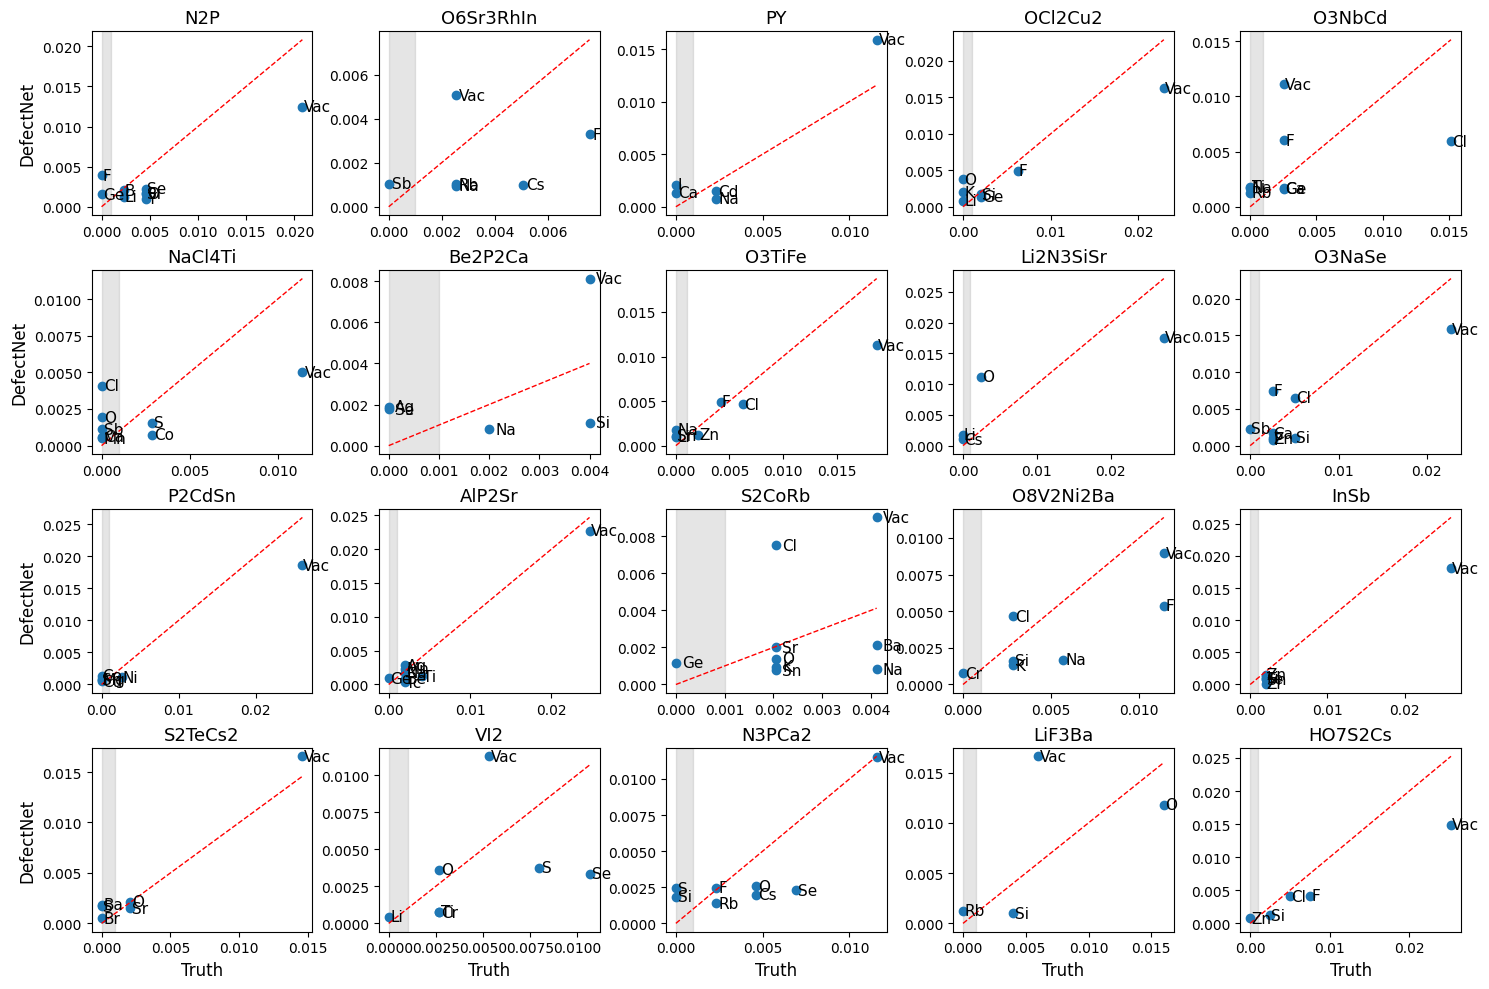

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 5, figsize=(15, 10))
axes = axes.flatten()

n_rows, n_cols = 4, 5

for i in range(20):
    if i >= len(plotted_results):
        break
    d = plotted_results[i]
    true = d['true']
    pred = d['pred']
    compound = d['formula']

    elements = list(pred.keys())
    true_vals = [true.get(elem, 0) for elem in elements]
    pred_vals = [pred[elem] for elem in elements]

    ax = axes[i]

    # Add shaded region around x=0 (e.g., from -0.001 to 0.001)
    ax.axvspan(0, 0.001, color='gray', alpha=0.2)

    ax.scatter(true_vals, pred_vals)
    ax.plot([0, max(true_vals)], [0, max(true_vals)], 'r--', lw=1)

    for x, y, elem in zip(true_vals, pred_vals, elements):
        ax.text(x + 0.00012, y, elem, fontsize=11, ha='left', va='center')

    ax.set_title(compound, fontsize=13)

    # Only show y-labels on the first column
    if i % n_cols == 0:
        ax.set_ylabel("DefectNet", fontsize=12)
    else:
        ax.set_ylabel('')

    # Only show x-labels on the bottom row
    if i // n_cols == n_rows - 1:
        ax.set_xlabel("Truth", fontsize=12)
    else:
        ax.set_xlabel('')

plt.tight_layout()
fig.subplots_adjust(wspace=0.3, hspace=0.3)
plt.savefig('DefectNet_test_results.pdf')
plt.show()

